In [1]:
%cd ../..

c:\Work\Modern Time Series Forecasting _ 2E\Modern-Time-Series-Forecasting-with-Python-2E


### Installing NeuralForecast (if not installed)

In [2]:
# %%capture
# !pip install neuralforecast

### Common Imports

In [3]:
import numpy as np
import pandas as pd

### Common Functions and metrics

- The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.Importing it from `src/utils/plotting_utils.
- `average_length` isn't implemented in `utilsforecast`, and therefore we have implemented it the same way as the rest of the metrics. Importing it from `src/utils/ts_utils.py`.
- `level_to_quantiles` is a function that converts a level to a quantile. Importing it from `src/utils/ts_utils.py`.

In [4]:
from src.utils.ts_utils import average_length, level_to_quantiles
from src.utils.plotting_utils import plot_grid

### Loading M4 Data

Let's load the data and pick 8 time series to work with.

In [5]:
from src.utils.general import download_m4_data
import os
if not os.path.exists('data/m4/M4-Hourly.csv'):
    download_m4_data()
Y_train_df = pd.read_csv('data/m4/M4-Hourly.csv')
Y_test_df = pd.read_csv('data/m4/M4-Hourly-test.csv')#.rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long.

In [6]:
# Taking first n_series time series from the dataset
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

### Plotting Sampled TS

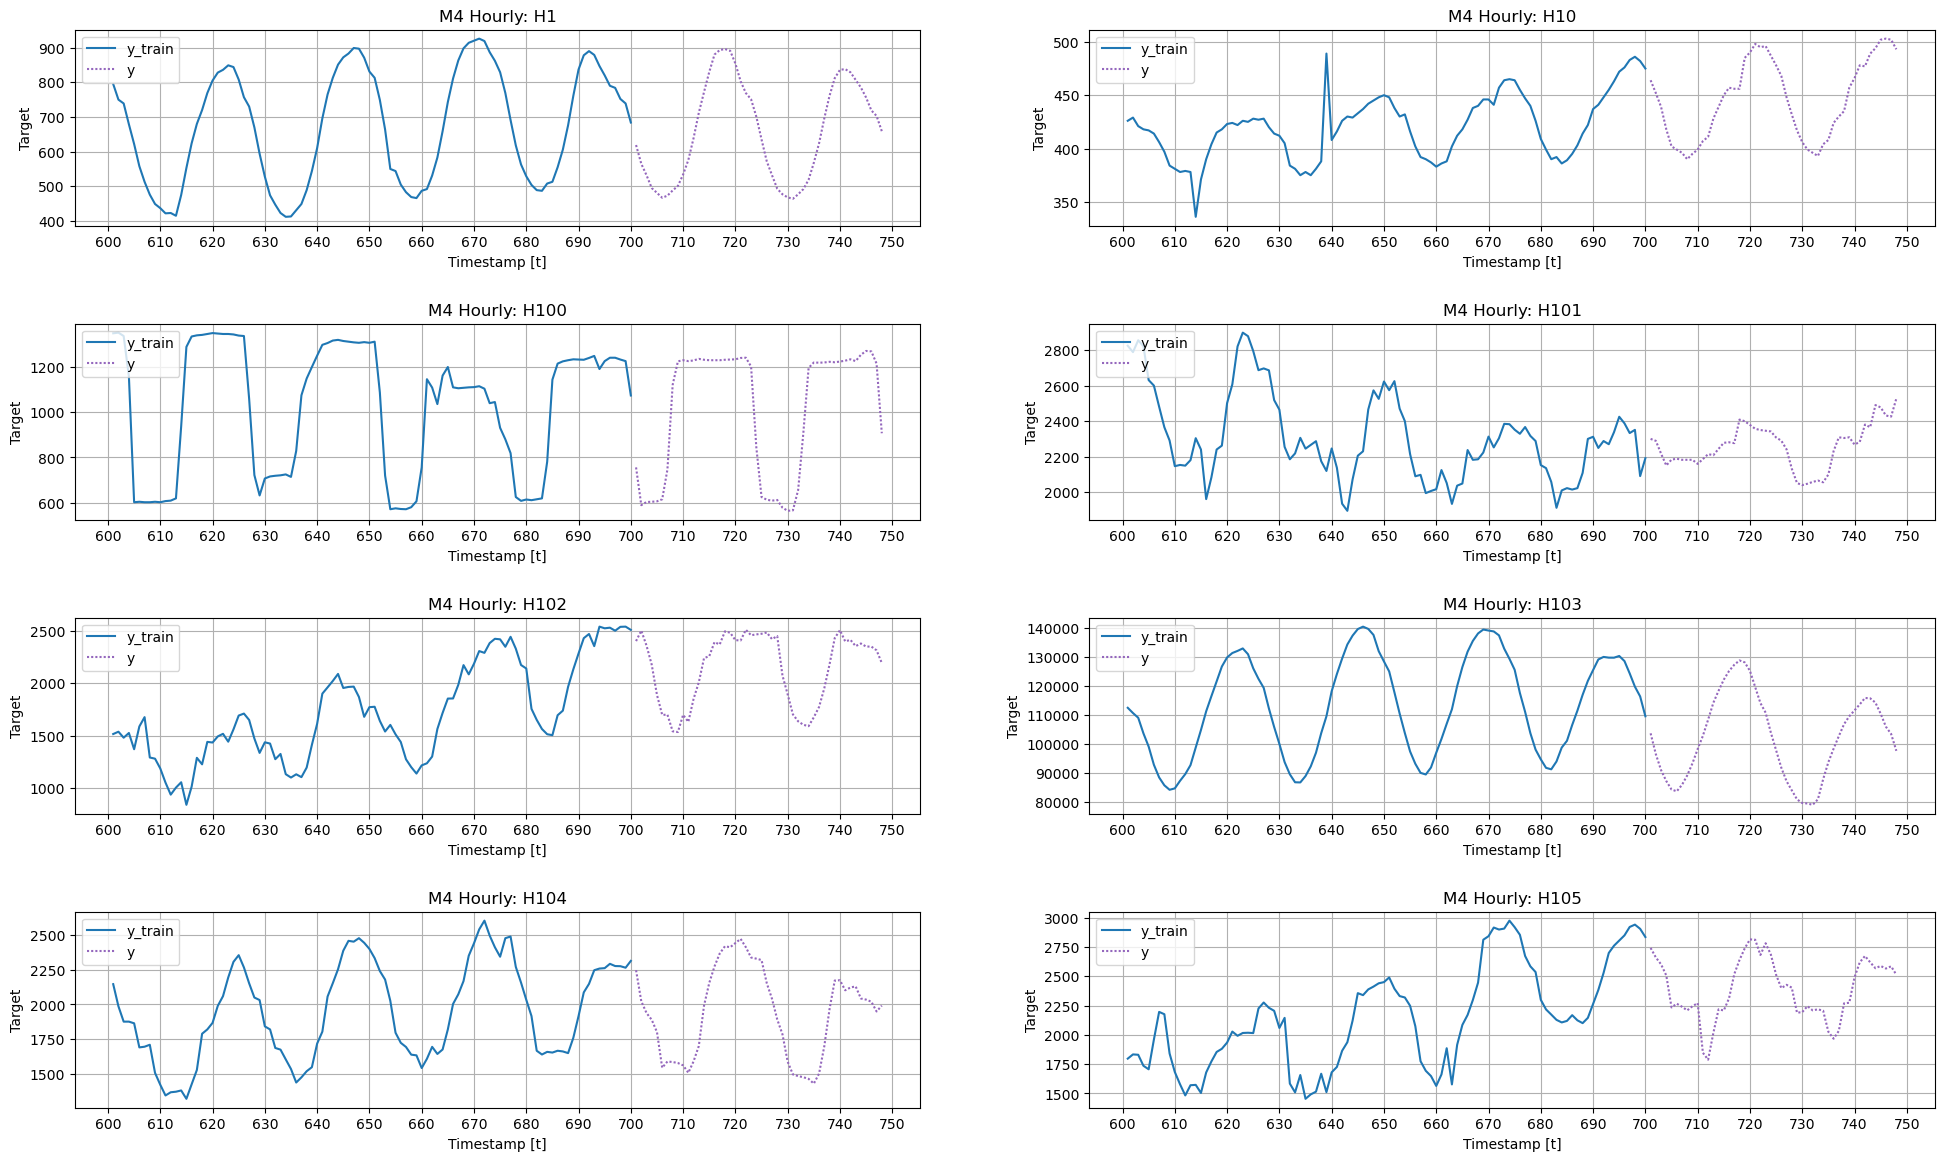

In [7]:
# Plotting the selected time series
plot_grid(Y_train_df, Y_test_df)

### Model Training

We have already seen how to use `neuralforecast` in Chapter 16. Here, lets see how we can use the same code and make it work for PDF prediction. We are going to use a simple LSTM, but the same strategy and code can be used for all the models in `neuralforecast`.

- The `horizon` parameter controls the number of steps ahead of the predictions, in this example 48 hours ahead (2 days).
- The `DistributionLoss` with `levels=[80,90]` specializes the network's output into the 80% and 90% prediction intervals.
- `input_size` controls the size of the context window
- `encoder_hidden_size` and `decoder_hidden_size` are parameters of the LSTM. We have kept it small so that the run's are faster. These parameters should be ideally tuned and we can use `AutoLSTM` or any of the `Auto<Model>` in `neuralforecast`.

In [8]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import DistributionLoss

In [9]:
horizon = len(Y_test_df.ds.unique()) # 48
levels = [80, 90]
lstm_config = dict(
    input_size=3 * horizon, encoder_hidden_size=8, decoder_hidden_size=8
)
models = [
    LSTM(
        h=horizon,
        loss=DistributionLoss(distribution="StudentT", level=levels),
        alias="LSTM_StudentT",
        **lstm_config
    ),
    LSTM(
        h=horizon,
        loss=DistributionLoss(distribution="Normal", level=levels),
        alias="LSTM_Normal",
        **lstm_config
    ),
]
# Setting freq=1 because the ds column is not date, but instead a sequentially increasing number
nf = NeuralForecast(models=models, freq=1)

Seed set to 1
Seed set to 1


All the models of the library are global, meaning that all time series in `Y_train_df` is used during a shared optimization to train a single model with shared parameters. This is the most common practice in the forecasting literature for deep learning models, and it is known as "cross-learning".

In [10]:
%%capture
nf.fit(df=Y_train_df)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss            | DistributionLoss | 5     
1 | padder          | ConstantPad1d    | 0     
2 | scaler          | TemporalNorm     | 0     
3 | hist_encoder    | LSTM             | 928   
4 | context_adapter | Linear           | 4.3 K 
5 | mlp_decoder     | MLP              | 115   
----------------------------------------

In [11]:
# Predicting for the next horizon (since we arent using any external regressors, we can just call predict)
# The output should have the point prediction (median) as well as the two prediction intervals according to the levels we have defined
Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,LSTM_StudentT,LSTM_StudentT-median,LSTM_StudentT-lo-90,LSTM_StudentT-lo-80,LSTM_StudentT-hi-80,LSTM_StudentT-hi-90,LSTM_Normal,LSTM_Normal-median,LSTM_Normal-lo-90,LSTM_Normal-lo-80,LSTM_Normal-hi-80,LSTM_Normal-hi-90
0,H1,701,594.455566,597.377319,474.439728,500.265381,683.934021,718.492432,616.703491,619.534912,521.795837,545.059814,688.169067,708.217590
1,H1,702,548.100403,546.707642,440.038483,475.454681,628.003235,653.708374,562.334778,560.504761,458.093842,483.508057,643.332581,663.967773
2,H1,703,503.756287,502.342285,368.430511,398.700653,602.779663,628.881409,519.117920,519.633301,391.767944,423.720459,619.691040,645.113220
3,H1,704,456.923340,458.770691,299.138763,346.188385,564.648499,604.949524,485.465942,485.538208,336.094666,370.945831,600.293884,624.541077
4,H1,705,440.777985,440.804565,306.110229,338.867737,546.077332,581.544189,452.580902,453.600586,305.091217,339.656403,564.460999,595.094727


In [12]:
# Merging the predictions back to the test_df
Y_test_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

### Plotting Predictions

Let's plot the forecast and see how we did.

The output that represents the 90% prediction interval of the network; its lower limit gives the 5th percentile (or 0.05 quantile) while its upper limit gives the 95th percentile (or 0.95 quantile). For well-trained models we expect that the target values lie within the interval 90% of the time.

#### LSTM_StudentT

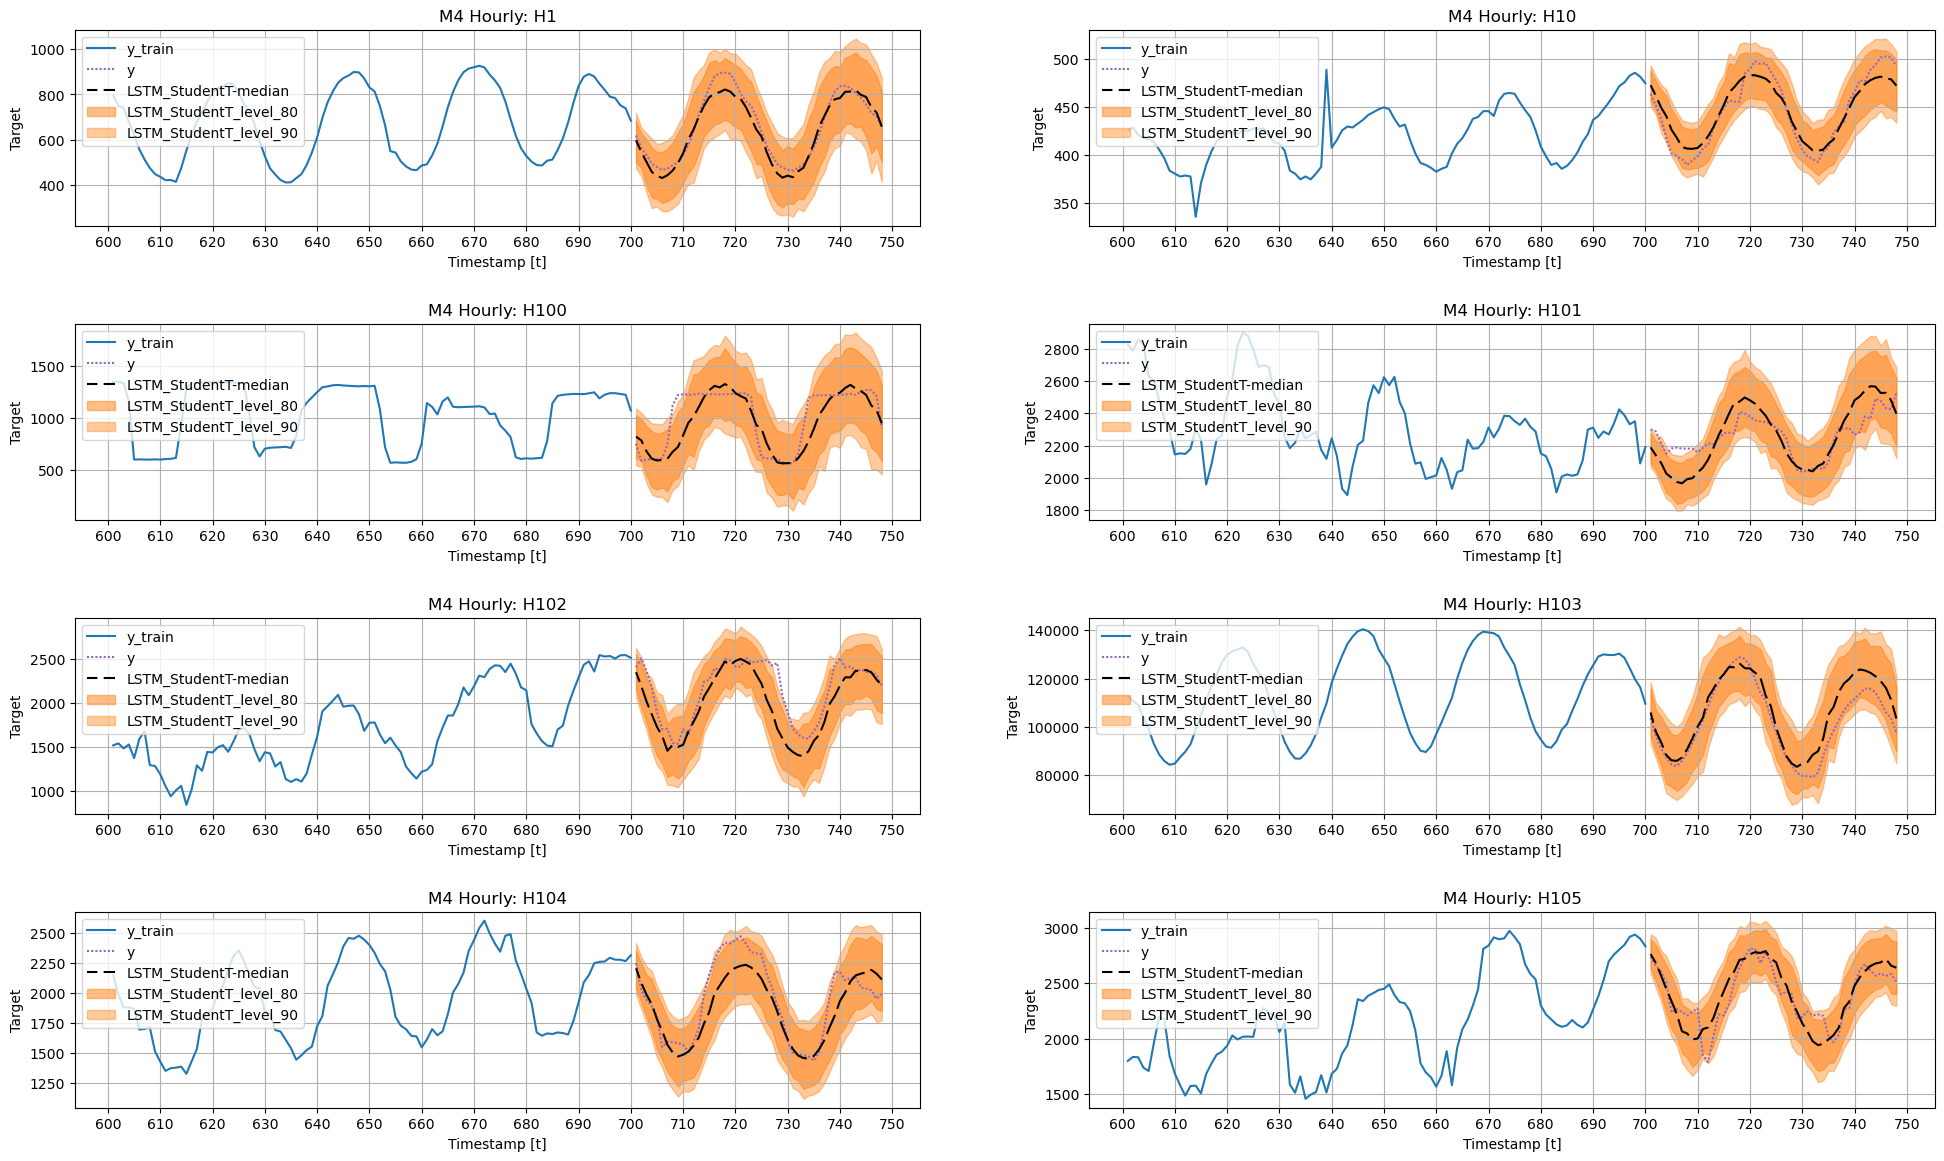

In [13]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM_StudentT')

#### LSTM_Normal

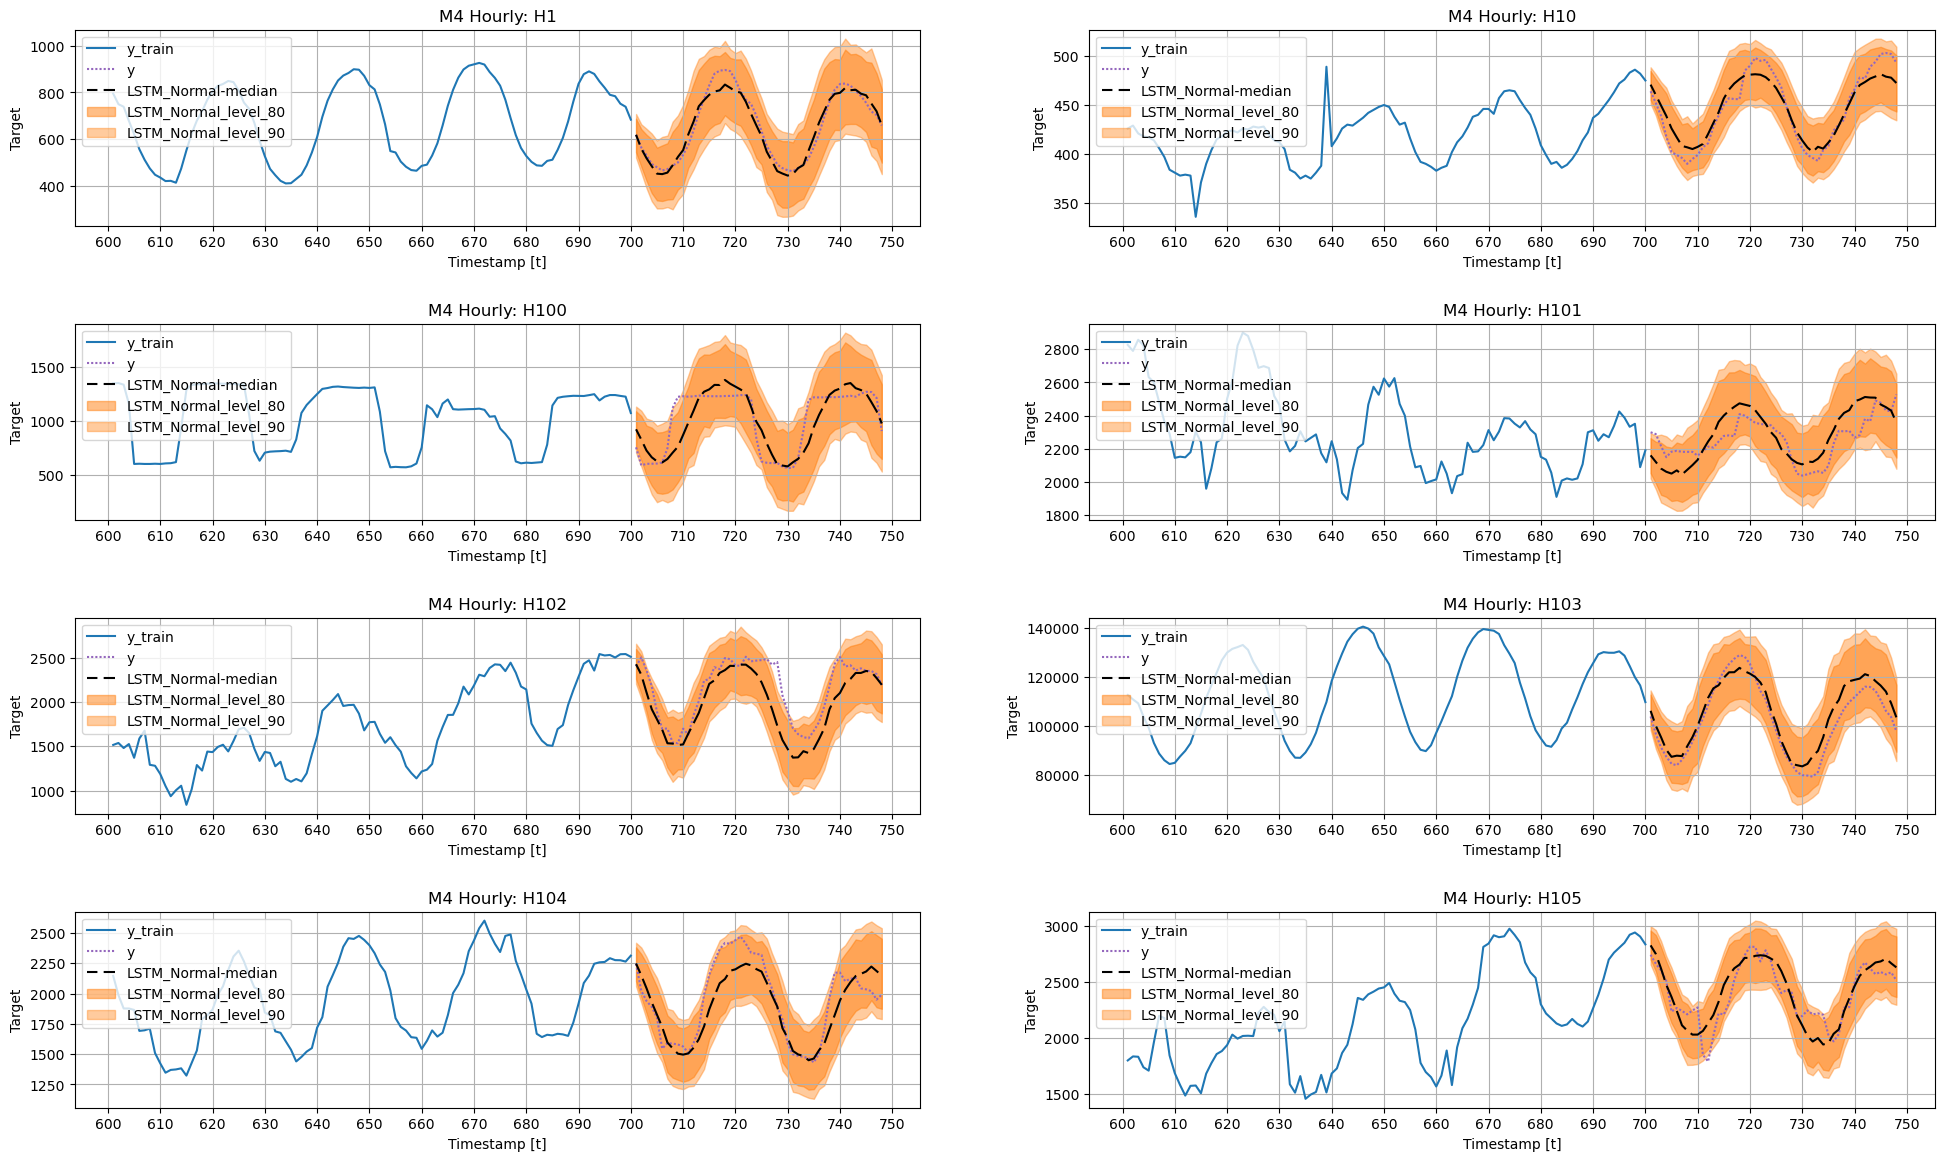

In [14]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM_Normal')

#### Metrics

In [15]:
from utilsforecast.losses import mae, coverage

In [16]:
res_df = mae(Y_test_df, models=['LSTM_StudentT-median']).rename(columns={'LSTM_StudentT-median': 'LSTM_StudentT-mae'})
res_df = res_df.merge(mae(Y_test_df, models=['LSTM_Normal-median']).rename(columns={'LSTM_Normal-median': 'LSTM_Normal-mae'}), on='unique_id')
for l in levels:
    res_df = res_df.merge(coverage(Y_test_df, models=['LSTM_Normal'], level=l).rename(columns={'LSTM_Normal': f'LSTM_Normal-coverage-{l}'}), on='unique_id')
    res_df = res_df.merge(average_length(Y_test_df, models=['LSTM_Normal'], level=l).rename(columns={'LSTM_Normal': f'LSTM_Normal-average_length-{l}'}), on='unique_id')
    res_df = res_df.merge(coverage(Y_test_df, models=['LSTM_StudentT'], level=l).rename(columns={'LSTM_StudentT': f'LSTM_StudentT-coverage-{l}'}), on='unique_id')
    res_df = res_df.merge(average_length(Y_test_df, models=['LSTM_StudentT'], level=l).rename(columns={'LSTM_StudentT': f'LSTM_StudentT-average_length-{l}'}), on='unique_id')
res_df

,unique_id,LSTM_StudentT-mae,LSTM_Normal-mae,LSTM_Normal-coverage-80,LSTM_Normal-average_length-80,LSTM_StudentT-coverage-80,LSTM_StudentT-average_length-80,LSTM_Normal-coverage-90,LSTM_Normal-average_length-90,LSTM_StudentT-coverage-90,LSTM_StudentT-average_length-90
0,H1,30.236069,25.624772,1.000000,283.496979,1.000000,277.002154,1.000000,364.234564,1.000000,379.727213
1,H10,10.624161,10.421406,0.979167,51.680541,0.958333,49.274955,1.000000,66.303233,1.000000,67.187339
2,H100,117.840120,121.935446,0.875000,650.567130,0.895833,641.255395,0.979167,830.685015,0.937500,879.152472
3,H101,92.860057,90.329717,0.958333,398.062027,0.750000,340.822159,0.958333,512.908348,0.875000,464.493647
4,H102,169.452031,173.042023,0.833333,633.416743,0.833333,619.196047,0.916667,813.279742,0.895833,847.938540
5,H103,4646.264323,4322.925293,1.000000,25270.319499,1.000000,24907.359212,1.000000,32457.823730,1.000000,33950.600911
6,H104,122.986824,119.372470,0.916667,510.660988,0.854167,493.365873,1.000000,655.989634,0.979167,666.488528
7,H105,110.559415,113.744522,0.854167,471.914998,0.854167,449.105464,0.979167,603.949382,1.000000,613.617622
